*Submitted by Ms.Chingmuankim Naulak*

Step1: *Importing libraries*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score, classification_report

RANDOM_STATE = 42
plt.style.use("seaborn-v0_8")

Step: 2 *Clean the data*

In [2]:
from pathlib import Path
import re

CSV_IN  = Path("survey_results_public.csv")     # raw CSV
CSV_OUT = CSV_IN.with_name(CSV_IN.stem + "__clean.csv")  # cleaned CSV path
ENCODINGS_TO_TRY = ["utf-8-sig", "utf-8", "latin-1"]

def repair_csv_quotes(in_path: Path, out_path: Path, encoding_candidates=ENCODINGS_TO_TRY):
    """
    Repairs common CSV issues:
    - CRLF/CR mixing → normalize to '\n'
    - Embedded newlines inside quoted fields → stitch lines until quotes are balanced
    - NUL bytes removed
    Returns the encoding used.
    """
    enc_used = None
    for enc in encoding_candidates:
        try:
            raw = in_path.read_text(encoding=enc, errors="strict")
            enc_used = enc
            break
        except Exception:
            continue
    if enc_used is None:
        # last resort: read ignoring errors
        enc_used = encoding_candidates[-1]
        raw = in_path.read_text(encoding=enc_used, errors="ignore")

    # Normalize newlines & strip NULs
    raw = raw.replace("\r\n", "\n").replace("\r", "\n").replace("\x00", "")

    # Stitch lines until we have an even number of double quotes
    out_lines = []
    buf = []
    quote_count = 0
    for line in raw.split("\n"):
        buf.append(line)
        quote_count += line.count('"')
        if quote_count % 2 == 0:
            # balanced → flush buffer as one line
            out_lines.append("\n".join(buf))
            buf = []
            quote_count = 0
    # If file ends with an unbalanced buffer, flush anyway
    if buf:
        out_lines.append("\n".join(buf))

    # Optional: collapse accidental internal newlines that got stitched
    # Replace internal newlines inside a row with literal spaces (safer for parsing)
    out_text = "\n".join(l.replace("\n", " ") for l in out_lines)

    out_path.write_text(out_text, encoding="utf-8")
    return enc_used

def try_read_csv(path: Path):
    # Try fast path
    try:
        return pd.read_csv(path, low_memory=False)
    except Exception:
        # Try python engine & skip irreparable rows
        return pd.read_csv(
            path,
            engine="python",
            on_bad_lines="skip",
            dtype=str,            # keep as strings first
            quotechar='"',
            escapechar="\\",
        )

#REPAIRING ERRORS IN ORIGINAL DATA
used = repair_csv_quotes(CSV_IN, CSV_OUT)
print(f"Cleaned CSV written to: {CSV_OUT} (source encoding: {used})")


Cleaned CSV written to: survey_results_public__clean.csv (source encoding: utf-8-sig)


Step: 3 *Load the data*

In [3]:
df = try_read_csv(CSV_OUT)
print("Loaded shape:", df.shape)
print("First columns:", list(df.columns)[:12])
df.head(3)

Loaded shape: (6727, 170)
First columns: ['ResponseId', 'MainBranch', 'Age', 'EdLevel', 'Employment', 'EmploymentAddl', 'WorkExp', 'LearnCodeChoose', 'LearnCode', 'LearnCodeAI', 'AILearnHow', 'YearsCode']


,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,...,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256,10
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413,9
2,3,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",None of the above,10,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Google Gemini,NaN,When I don’t trust AI’s answers;When I want to...,"Understand how things actually work, problem s...",53061,8


Step 4: *Exploratory Data Analysis*

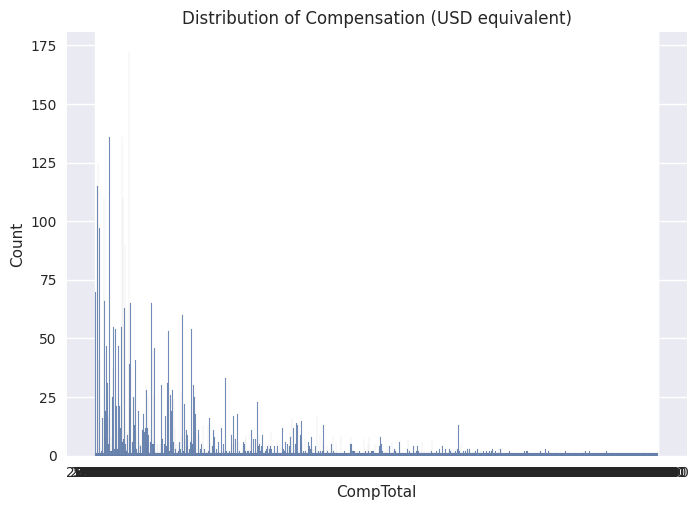

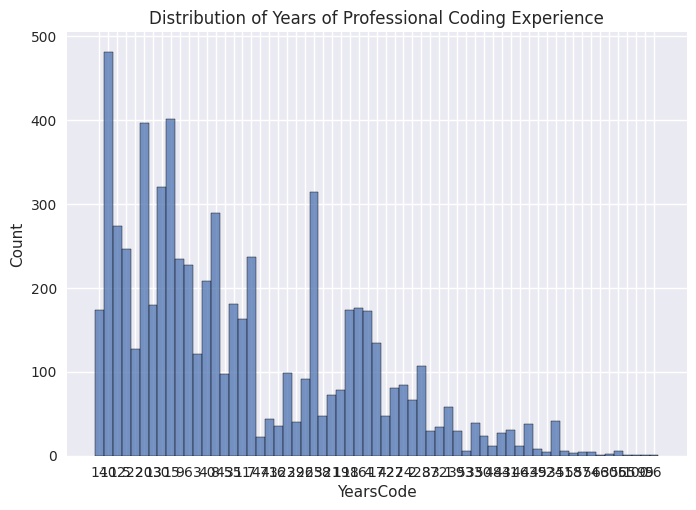

In [4]:
# Compensation distribution
sns.histplot(df["CompTotal"], bins=50)
plt.title("Distribution of Compensation (USD equivalent)")
plt.show()

# Years coding distribution
sns.histplot(df["YearsCode"], bins=30)
plt.title("Distribution of Years of Professional Coding Experience")
plt.show()

Step 5: *Data Cleaning*

In [6]:
df_model = df.dropna(subset=["ConvertedCompYearly"]).copy()
features = ["Country", "YearsCode", "LearnCodeChoose", "AILearnHow"]
target = "ConvertedCompYearly"

# Convert YearsCodePro to numeric
df_model["YearsCode"] = pd.to_numeric(df_model["YearsCode"], errors="coerce")
df_model = df_model.dropna(subset=["YearsCode"])

X = df_model[features]
#y = np.log1p(df_model[target]) 
y = np.log1p(df_model[target].astype(float)) 

Step 6: *Preprocessing*

In [8]:
numeric_features = ["YearsCode"]
categorical_features = ["Country", "LearnCodeChoose", "AILearnHow"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


Step 7: *Modelling*

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_STATE)

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE))
])

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


R2: 0.22995922434865435
RMSE: 1.1800722795570338


/opt/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Step 8: *Feature Importance Visualization*

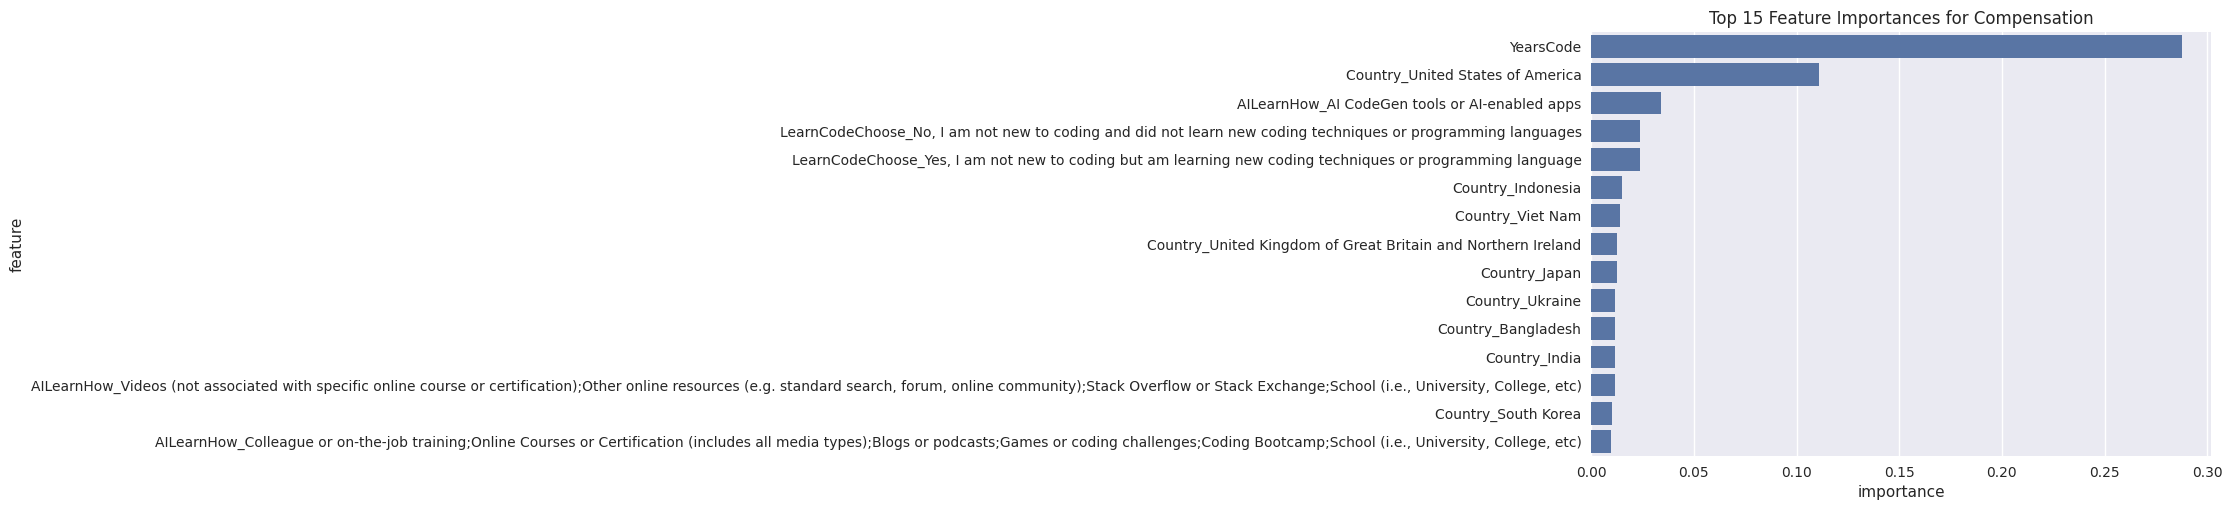

In [10]:
ohe = rf.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)

importances = rf.named_steps["model"].feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False).head(15)

sns.barplot(x="importance", y="feature", data=imp_df)
plt.title("Top 15 Feature Importances for Compensation")
plt.show()


Step 9: *Creative Scenario Prediction*

In [12]:
new_dev = pd.DataFrame({
    "Country": ["India"],
    "YearsCode": [5],
    "LearnCodeChoose": ["Python;TypeScript"],
    "AILearnHow": ["AI coding assistant"]
})

predicted_salary = np.expm1(rf.predict(new_dev))[0]
print(f"Predicted annual compensation: ${predicted_salary:,.0f} USD equivalent")

Predicted annual compensation: $8,764 USD equivalent


# A. Compensation Prediction (Regression)

Compensation Model Performance
R2: 0.22995922434865435
RMSE: 1.1800722795570338


/opt/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


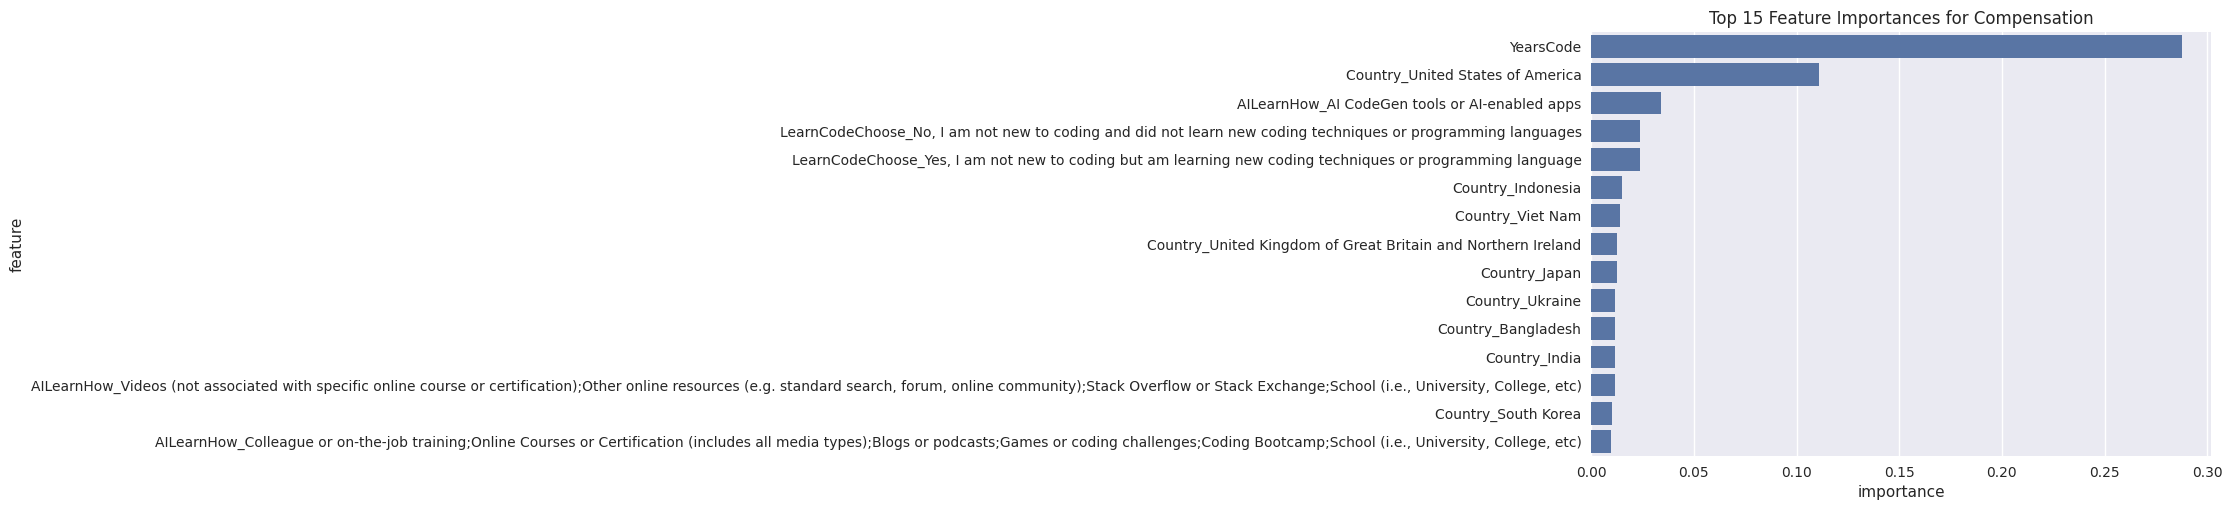

In [14]:
#Model: Random Forest Regressor

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE))
])

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Compensation Model Performance")
print("R2:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Feature Importance
ohe = rf.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)

importances = rf.named_steps["model"].feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False).head(15)

sns.barplot(x="importance", y="feature", data=imp_df)
plt.title("Top 15 Feature Importances for Compensation")
plt.show()

## B. Job Satisfaction Prediction (Classification)

In [22]:
# Keep subset with JobSat responses
df_class = df.dropna(subset=["JobSat"]).copy()

# Convert JobSat to binary target
# Example: "Very satisfied" / "Slightly satisfied" → 1, others → 0
df_class["JobSatBinary"] = df_class["JobSat"].apply(
    lambda x: 1 if "satisfied" in str(x).lower() else 0
)

# Features: Similar to regression, but can add WorkWeekHrs
features_class = ["Country", "YearsCode", "LearnCodeChoose", "AILearnHow", "WorkExp"]
target_class = "JobSatBinary"

# Preprocess features
df_class["YearsCode"] = pd.to_numeric(df_class["YearsCode"], errors="coerce")
df_class = df_class.dropna(subset=["YearsCode", "WorkExp"])

Xc = df_class[features_class]
yc = df_class[target_class]


In [25]:
# --- Preprocessing for classification ---
numeric_features_class = ["YearsCode", "WorkExp"]
categorical_features_class = ["Country", "LearnCodeChoose", "AILearnHow"]

numeric_transformer_class = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_class = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_class = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_class, numeric_features_class),
        ("cat", categorical_transformer_class, categorical_features_class)
    ]
)

In [26]:
# --- Train/Test Split ---
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, random_state=RANDOM_STATE, stratify=yc
)

clf = Pipeline(steps=[
    ("preprocess", preprocess_class),
    ("model", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE))
])

clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)

print("Job Satisfaction Model Performance")
print("Accuracy:", accuracy_score(yc_test, yc_pred))
print("F1:", f1_score(yc_test, yc_pred))
print("\nClassification Report:\n", classification_report(yc_test, yc_pred))


Job Satisfaction Model Performance
Accuracy: 1.0
F1: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1004

    accuracy                           1.00      1004
   macro avg       1.00      1.00      1.00      1004
weighted avg       1.00      1.00      1.00      1004



/opt/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## C. Feature Importance for Classification

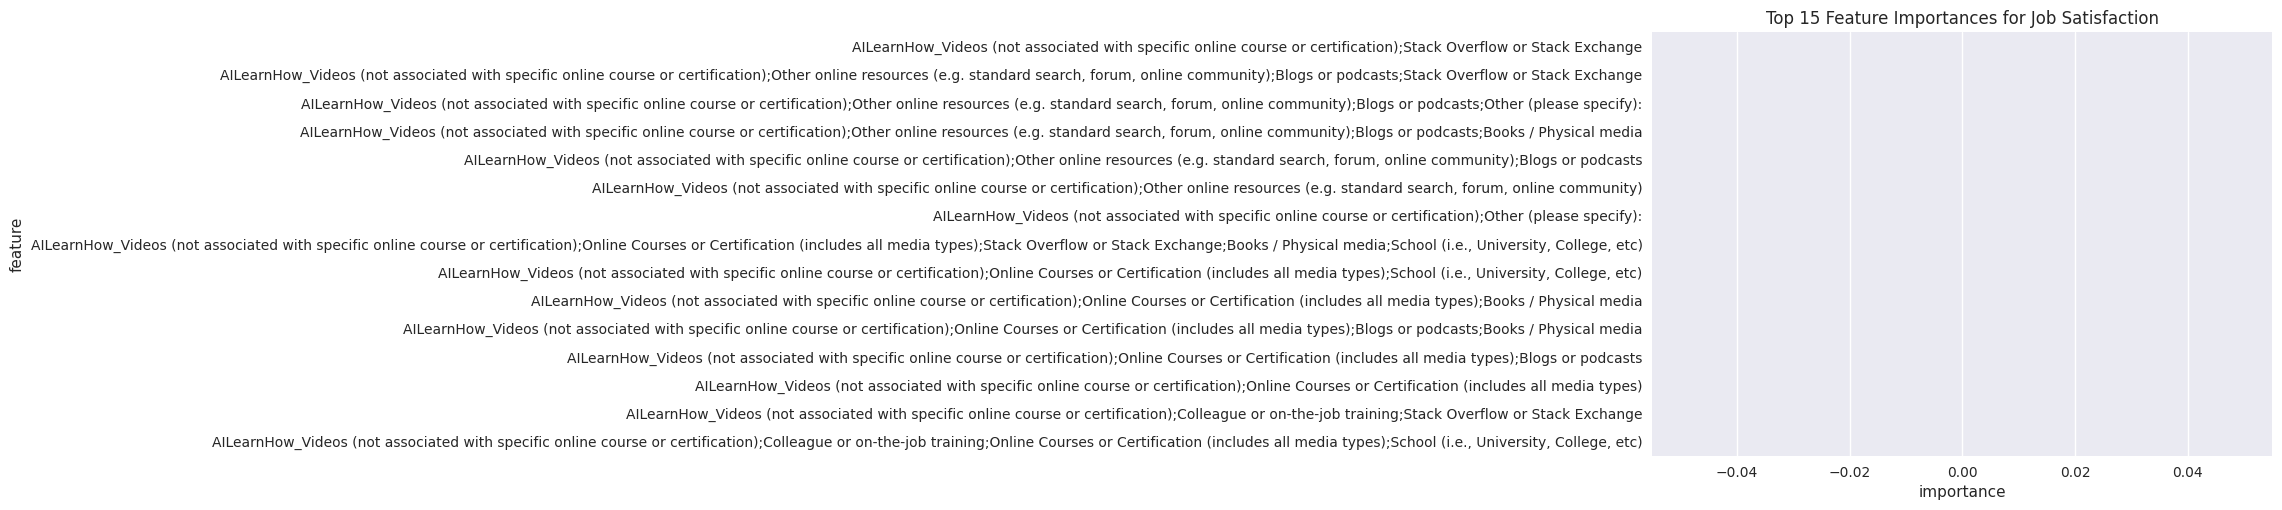

In [27]:
# Feature importances
ohe_class = clf.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
cat_names_class = ohe_class.get_feature_names_out(categorical_features_class)
feature_names_class = numeric_features_class + list(cat_names_class)

importances_class = clf.named_steps["model"].feature_importances_
imp_class_df = pd.DataFrame({"feature": feature_names_class, "importance": importances_class})
imp_class_df = imp_class_df.sort_values("importance", ascending=False).head(15)

sns.barplot(x="importance", y="feature", data=imp_class_df)
plt.title("Top 15 Feature Importances for Job Satisfaction")
plt.show()

## D. Creative Scenario (Classification)

In [29]:
# Creative Scenario for Job Satisfaction
new_dev_class = pd.DataFrame({
    "Country": ["India"],
    "YearsCode": [5],
    "LearnCodeChoose": ["Python;TypeScript"],
    "AILearnHow": ["AI coding assistant"],
    "WorkExp": [40]
})

satisfaction_pred = clf.predict(new_dev_class)[0]
print("Predicted Job Satisfaction:", "Satisfied" if satisfaction_pred == 1 else "Not satisfied")

Predicted Job Satisfaction: Not satisfied
